In [1]:
#  STEP 1: Install dependencies
! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip NDVI files from Google Drive
import shutil

zip_path = "/content/drive/MyDrive/ndvi_july_dec_2024.zip"
extract_to = "/content/ndvi_july_dec_2024"

# Copy zip to /content before unzipping
shutil.copy(zip_path, "/content/ndvi_july_dec_2024.zip")
!unzip -q /content/ndvi_july_dec_2024.zip -d /content/ndvi_july_dec_2024
!ls -R /content/ndvi_july_dec_2024

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# folder = "/content/ndvi_tiffs"
folder = "/content/ndvi_july_dec_2024/ndvi_july_dec_2024"
# folder = "/kaggle/input/ndvi-jan-june-2022/ndvi_tiffs/"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndvi_stack = []

print("Reading NDVI images...")

for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndvi_stack.append(data)

print(type(ndvi_stack[0]))
ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
time, height, width = ndvi_stack.shape

print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

print("NDVI shape:", ndvi_stack.shape)
print("NDVI stats:", np.nanmin(ndvi_stack), np.nanmax(ndvi_stack))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.2 MB/s eta 0:00:00
Mounted at /content/drive
/content/ndvi_july_dec_2024:
ndvi_july_dec_2024

/content/ndvi_july_dec_2024/ndvi_july_dec_2024:
NDVI_07_July_2024_Krishna.tif	    NDVI_10_October_2024_Krishna.tif
NDVI_08_August_2024_Krishna.tif     NDVI_11_November_2024_Krishna.tif
NDVI_09_September_2024_Krishna.tif  NDVI_12_December_2024_Krishna.tif
['NDVI_07_July_2024_Krishna.tif', 'NDVI_08_August_2024_Krishna.tif', 'NDVI_09_September_2024_Krishna.tif', 'NDVI_10_October_2024_Krishna.tif', 'NDVI_11_November_2024_Krishna.tif', 'NDVI_12_December_2024_Krishna.tif']
Reading NDVI images...
<class 'numpy.ndarray'>
Loaded NDVI stack with shape: (6, 5308, 5811)
NDVI shape: (6, 5308, 5811)
NDVI stats: -0.99862754 0.99999404


In [2]:
ndvi_stack

for i, layer in enumerate(ndvi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndvi_stack).sum()
print("Total NaN values in NDVI stack:", total_nans)

total_pixels = np.prod(ndvi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")


Time step 0: 21031701 NaN values
Time step 1: 21026316 NaN values
Time step 2: 21053832 NaN values
Time step 3: 21026870 NaN values
Time step 4: 21037024 NaN values
Time step 5: 21074945 NaN values
Total NaN values in NDVI stack: 126250688
Percentage of NaN values: 68.22%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


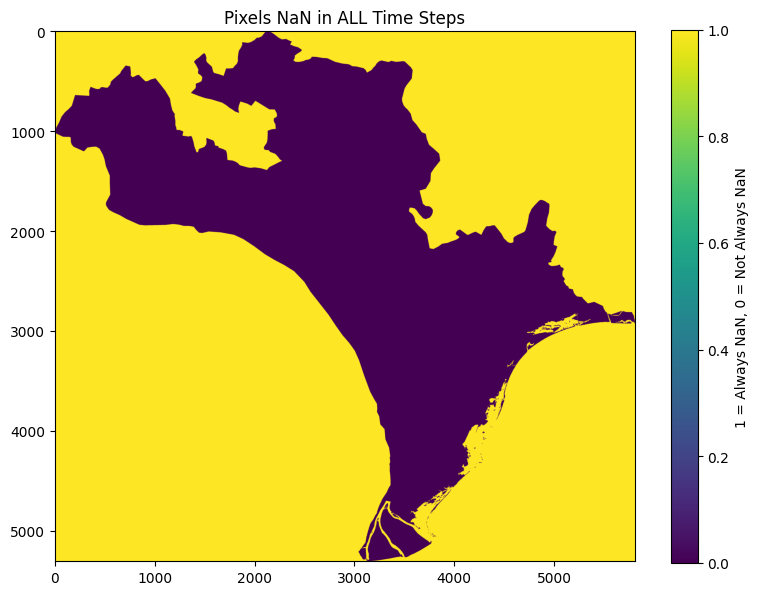

In [3]:
nan_masks = np.isnan(ndvi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [4]:
ndvi_scaled = np.empty_like(ndvi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndvi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndvi_scaled[:, i, j] = np.nan
        else:
            ndvi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val

Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [06:30<00:00, 13.59it/s]


In [5]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndvi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndvi_scaled[:, i, j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [02:00<00:00, 43.99it/s]


Training data prepared: X shape: (9713131, 5, 1), y shape: (9713131,)


In [6]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # NDVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "/content/drive/MyDrive/ndvi_lstm_model_jan_2025.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 351s 91ms/step - loss: 47803.5742 - val_loss: 0.2097
Epoch 2/5
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 374s 89ms/step - loss: 0.1299 - val_loss: 0.1140
Epoch 3/5
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 377s 88ms/step - loss: 0.1004 - val_loss: 0.1407
Epoch 4/5
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 331s 87ms/step - loss: 0.0996 - val_loss: 0.2815
Epoch 5/5
3795/3795 ━━━━━━━━━━━━━━━━━━━━ 328s 86ms/step - loss: 0.1104 - val_loss: 0.1129


In [7]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting NDVI for the 7th month...")
X_test=[]
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        if normalized:
            series=ndvi_scaled[:,i,j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use all 6 months to predict the 7th month

        X_test.append(series[1:])
        coords_test.append([i,j])

        # # Inverse transform the prediction to original scale
        # if scalers[i, j] is not None:
        #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting NDVI for the 7th month...


100%|██████████| 5308/5308 [01:55<00:00, 46.13it/s]


In [8]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4743/4743 ━━━━━━━━━━━━━━━━━━━━ 167s 35ms/step
converting back to 2d grid
(9713131, 1)


0it [00:00, ?it/s]<ipython-input-8-2dbf15bb067a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9713131it [01:47, 90496.86it/s]


Saving prediction to GeoTIFF...
Prediction saved as: predicted_ndvi_jan_2025.tif


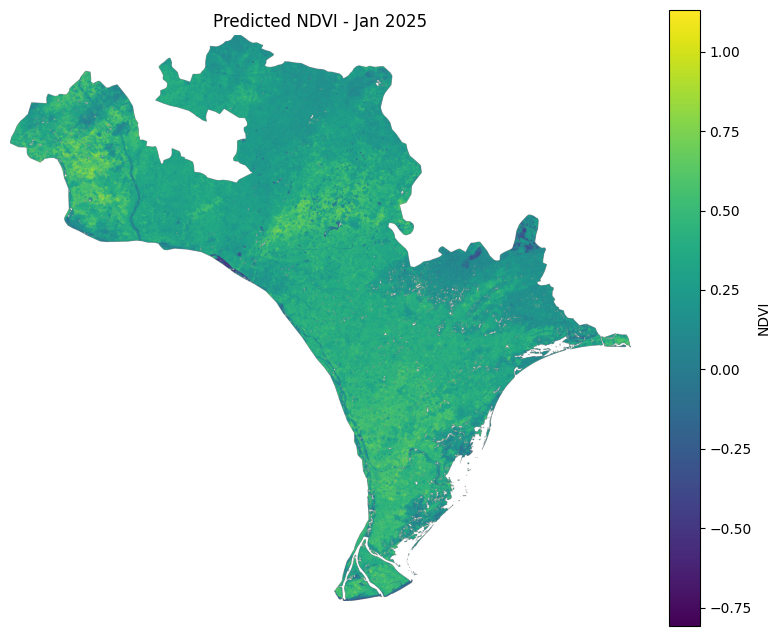

In [9]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("/content/drive/MyDrive/predicted_ndvi_jan_2025.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("Prediction saved as: predicted_ndvi_jan_2025.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title("Predicted NDVI - Jan 2025")
plt.axis('off')
plt.savefig("/content/drive/MyDrive/predicted_ndvi_jan_2025.png", dpi=300)
plt.show()